<a href="https://colab.research.google.com/github/fotkarra/datastories_for_emme/blob/main/ergasia_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import requests # για να φέρνουμε τον html κώδικα των ιστοσελίδων
from bs4 import BeautifulSoup # για να βρίσκουμε μέσα στον html κώδικα, τα περιεχόμενα που μας ενδιαφέρουν
import pandas as pd # για να βάζουμε τα δεδομένα που συλλέγουμε σε dataframes

import time # για να κάνουμε παύσεις ανάμεσα στα αιτήματα που κάνουμε στον server του site ώστε να μην τον ρίξουμε ή να μην μας αποκλείσει
import random # για να δημιουργούμε ποικιλία στον χρόνο των παύσεων ώστε τα αιτήματα στον server να μοιάζουν με ανθρώπινα και όχι μηχανικά

from tqdm import tqdm # για να βάλω progress bar με το οποίο θα παρακολουθώ την πορεία του scraping

In [82]:
def get_webpage_soup(url):
  # Ορισμός των headers για το requests
  headers = {
        "User-Agent": "Mozilla/5.0"
    }
  # Αίτημα στο server να φέρει τον html κώδικα από το url
  response = requests.get(url, headers=headers)

  # Έλεγχος της κατάστασης της σελίδας
  if response.status_code != 200:
    #print(f"Error: {response.status_code}")
    return None
  else:
    # Μετατροπή του πηγαίου κώδικα της ιστοσελίδας σε αναζητήσιμο κείμενο (soup)
    # print(f"{url} was scraped successfully")
    return BeautifulSoup(response.text, 'html.parser')

In [83]:
def get_article_elements_from_soup(soup, article_url):
  # απομόνωση του block με το περιεχόμενο του άρθρου απόο όλη τη σούπα της σελίδας
  article_block = soup.find("article")
  # article url
  article_url = article_url # το παίρνω από το arguement του function
  # title
  try:
    title = soup.find("h1" , class_=lambda c: c and "title" in c).text.strip()
  except:
    title=""
  # datetime
  try:
    datetime_str = soup.find("time")["datetime"]
    date_str = datetime_str.split("T")[0]
    time_str = datetime_str.split("T")[1].split("+")[0]
  except:
    date_str = ""
    time_str = ""
  # section
  try:
    section = soup.find("div", class_="post-category blue").text.strip().replace("\n", "")
  except:
    section = ""
  # author
  try:
    author = soup.find("div", class_="post-author").text.strip()
  except:
    author = ""
  # excerpt
  try:
   excerpt = soup.find("div", class_="post-content mb-25").find("h3").text.strip()
   excerpt = excerpt.replace("\xa0", "").strip()
  except:
    excerpt=""
  # text body
  try:
    text_body_p_tagsL = article_block.find("div", class_= "post-content mb-25").find_all("p")
    text_body_textsL = []
    for p_tag in text_body_p_tagsL:
      p_tag_text = p_tag.text.strip()
      text_body_textsL.append(p_tag_text)
    text_body = " ".join(text_body_textsL)
  except:
    text_body=""
  # feature image
  try:
    feat_img_link = soup.find("img", src=True)["src"]
  except:
    feat_img_link=""
  # feature image caption
  try:
    image_caption = soup.find("div", class_="entry-summary").find("p").text.strip()
  except:
    image_caption=""

  # Δημιουργία λεξικού με τα data του άρθρου
  articleD = {"article_url": article_url, "title": title, "date": date_str, "time": time_str, "section": section,
              "excerpt": excerpt, "text_body": text_body, "feat_img_link": feat_img_link, "feat_img_cation": image_caption}

  return articleD

In [84]:
def scrape_naftemporiki_articles_pages(teasers_df):
  # δημιουργία κενής λίστας στην οποία θα προσθέτουμε ένα-ένα τα λεξικά με τα δεδομένα των άρθρων που θα σκραπάρουμε
  all_articles_dataL = []
  # λούπα σε κάθε row του teasers_df για να παίρνουμε ένα-ένα τα urls των άρθρων και να το σκραπάρουμε
  # χρησιμοποιούμε το tqdm για να βλέπουμε σε ένα progress bar πού βρισκόμαστε και πόσος χρόνος απομένει ακόμα
  for idx, row in tqdm(teasers_df.iterrows(), total=teasers_df.shape[0], desc="Processing rows"):
    # παίρνουμε το url του άρθρου που θα σκραπάρουμε από τη στήλη "article_url" του row του teasers_df στο οποίο βρίσκεται η for loop
    article_url = row['article_url']
    # scrape της σελίδας του url του κάθε άρθρου με το function που φτιάξαμε στο βήμα 2
    soup = get_webpage_soup(article_url)
    # δημιουργία του λεξικού με τα δεδομένα του κάθε άρθρου με το function που φτιάξαμε στο βήμα 9
    articleD = get_article_elements_from_soup(soup, article_url)
    # προσθήκη του λεξικού με τα δεδομένα του κάθε άρθρου στη λίστα που δημιουργήσαμε στη αρχή
    all_articles_dataL.append(articleD)
    # καθυστέρηση ανάμεσα στα requests στο server
    delay = random.uniform(1, 3)
    time.sleep(delay)
  # δημιουργία dataframe από τη λίστα των λεξικών με τα δεδομένα κάθε άρθρου
  df = pd.DataFrame(all_articles_dataL)
  print(f"\nScraping completed. Fetshed {len(df)} articles.")
  return df

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Δοκιμή του scraper

In [86]:
teasers_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/trump_naftemporiki.csv")
teasers_df.head()

,title,article_url,date,time,section
0,«Δεν είναι προς πώληση» – «Ποτέ μην λες ποτέ» ...,https://www.naftemporiki.gr/kosmos/1953073/den...,06/05/2025,20:06,Κόσμος
1,Τραμπ: Οι Χούθι «συνθηκολόγησαν» – Οι αμερικαν...,https://www.naftemporiki.gr/kosmos/1953070/tra...,06/05/2025,19:47,Κόσμος
2,Τραμπ: «Η μοναδική μου ερώτηση στον πρωθυπουρ...,https://www.naftemporiki.gr/kosmos/1953067/tra...,06/05/2025,19:46,Κόσμος
3,Γρ. Ζαρωτιάδης στη «Ν» για δασμούς: Οδηγούμαστ...,https://www.naftemporiki.gr/finance/world/1952...,06/05/2025,17:07,Διεθνή
4,"Πούλιτζερ 2025: Η απόπειρα κατά του Τραμπ, τα ...",https://www.naftemporiki.gr/kosmos/1952721/poy...,06/05/2025,11:03,Κόσμος


In [87]:
articles_df = scrape_naftemporiki_articles_pages(teasers_df)

Processing rows: 100%|██████████| 30/30 [01:05<00:00,  2.18s/it]


Scraping completed. Fetshed 30 articles.


In [88]:
articles_df

,article_url,title,date,time,section,excerpt,text_body,feat_img_link,feat_img_cation
0,https://www.naftemporiki.gr/kosmos/1953073/den...,«Δεν είναι προς πώληση» – «Ποτέ μην λες ποτέ» ...,2025-05-06,20:06:38,Κόσμος,Είχε προηγηθεί μία προσβλητική ανάρτηση του Ντ...,"«Χρειάζονται δύο για να χορέψεις τανγκό, σωστά...",https://www.naftemporiki.gr/wp-content/themes/...,"Η στιγμή του εκνευρισμού του Μαρκ Κάρνει, όταν..."
1,https://www.naftemporiki.gr/kosmos/1953070/tra...,Τραμπ: Οι Χούθι «συνθηκολόγησαν» – Οι αμερικαν...,2025-05-06,19:47:02,Κόσμος,Ο Αμερικανός πρόεδρος Ντόναλντ Τραμπ ανακοίνωσ...,«Οι Χούθι ανακοίνωσαν (…) ότι δεν θέλουν πλέον...,https://www.naftemporiki.gr/wp-content/themes/...,Δηλώσεις του προέδρου των ΗΠΑ
2,https://www.naftemporiki.gr/kosmos/1953067/tra...,Τραμπ: «Η μοναδική μου ερώτηση στον πρωθυπουρ...,2025-05-06,19:46:28,Κόσμος,"Έφτασε στον Λευκό Οίκο, για την πρώτη συνάντησ...",Το Φιλελεύθερο κόμμα του Κάρνεϊ κέρδισε τις εκ...,https://www.naftemporiki.gr/wp-content/themes/...,"Η προσβολή με ανάρτηση, προς τον Μαρκ Κάρνει, ..."
3,https://www.naftemporiki.gr/finance/world/1952...,Γρ. Ζαρωτιάδης στη «Ν» για δασμούς: Οδηγούμαστ...,2025-05-06,17:07:33,Οικονομία & Αγορές \Διεθνή,«Το πλεόνασμα να αξιοποιηθεί αναπτυξιακά σε συ...,Σχολιάζοντας τη μη εκλογή του Φρίντριχ Μερτς ω...,https://www.naftemporiki.gr/wp-content/themes/...,Σχολίασε και τις επιπτώσεις από την πολιτική κ...
4,https://www.naftemporiki.gr/kosmos/1952721/poy...,"Πούλιτζερ 2025: Η απόπειρα κατά του Τραμπ, τα ...",2025-05-06,11:03:50,Κόσμος,Ρεπορτάζ που αποκαλύπτουν τη βαθιά σχέση του Έ...,"Τα Πούλιτζερ, τα σημαντικότερα δημοσιογραφικά ...",https://www.naftemporiki.gr/wp-content/themes/...,"Wall Street Journal, Reuters, Washington Post ..."
5,https://www.naftemporiki.gr/finance/markets/19...,Ρογκόφ: Πώς ο Τραμπ και ο Ρασπούτιν του επιταχ...,2025-05-06,10:35:47,Οικονομία & Αγορές \Αγορές,"«Δεν σε σκοτώνει αυτό που δεν ξέρεις, αλλά αυτ...",Όπως σχολιάζει ο Ρογκόφ σε άρθρο του στον Econ...,https://www.naftemporiki.gr/wp-content/themes/...,Η ισχύς του δολαρίου είχε αρχίσει να φθίνει πρ...
6,https://www.naftemporiki.gr/kosmos/1952702/tra...,Τραμπ: Πιο ανοιχτός στην ειρήνη ο Πούτιν μετά ...,2025-05-06,09:54:16,Κόσμος,Ο Αμερικανός πρόεδρος Ντόναλντ Τραμπ εκτίμησε ...,"«Πιστεύω ότι η Ρωσία, με την τιμή του πετρελαί...",https://www.naftemporiki.gr/wp-content/themes/...,Η τιμή του πετρελαίου έχει υποχωρήσει γύρω στα...
7,https://www.naftemporiki.gr/kosmos/1952696/sti...,Στις ΗΠΑ ο Κάρνεϊ: «Ο Καναδάς θέλει συμφωνία μ...,2025-05-06,09:25:30,Κόσμος,Ο Ντόναλντ Τραμπ υποδέχεται σήμερα στον Λευκό ...,Ο Κάρνεϊ δήλωσε πριν από την επίσκεψη ότι η συ...,https://www.naftemporiki.gr/wp-content/themes/...,Ο Ντόναλντ Τραμπ υποδέχεται στον Λευκό Οίκο το...
8,https://www.naftemporiki.gr/finance/economy/19...,ΣΕΒΕ: Συγκρατημένη αισιοδοξία για τους δασμούς...,2025-05-06,08:05:03,Οικονομία & Αγορές \Οικονομία,Συγκρατημένη αισιοδοξία για την έκβαση των δασ...,Στο πλαίσιο του εν λόγω ταξιδιού ο πρόεδρος το...,https://www.naftemporiki.gr/wp-content/themes/...,«Η Ελλάδα και άλλες χώρες έχουμε μικρά πλεονάσ...
9,https://www.naftemporiki.gr/kosmos/1952640/par...,Παραδοχή Τραμπ ότι ίσως δεν είναι εφικτή η ειρ...,2025-05-05,22:48:08,Κόσμος,"Για πρώτη φορά, ο Ντόναλντ Τραμπ παραδέχτηκε ό...","Μιλώντας την εκπομπή Meet the Press, του NBC, ...",https://www.naftemporiki.gr/wp-content/themes/...,"Ο Αμερικανός πρόεδρος, υποστήριξε ότι Ευρωπαί..."


In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
import pandas as pd
articles_df.to_csv('/content/drive/MyDrive/trump_articles.csv', index=False,)

In [91]:
def clean_text(text):
  cleaned_text =  text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')  #για να καθαρισουμε τα κείμενα
  cleaned_text = " ".join(cleaned_text.split())
  return cleaned_text

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import seaborn as sns

In [93]:
!python -m spacy download el_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 93.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [94]:
nlp = spacy.load('el_core_news_sm')

In [95]:
trump_full_articles_df = pd.read_csv('/content/drive/MyDrive/trump_articles.csv')
trump_full_articles_df

,article_url,title,date,time,section,excerpt,text_body,feat_img_link,feat_img_cation
0,https://www.naftemporiki.gr/kosmos/1953073/den...,«Δεν είναι προς πώληση» – «Ποτέ μην λες ποτέ» ...,2025-05-06,20:06:38,Κόσμος,Είχε προηγηθεί μία προσβλητική ανάρτηση του Ντ...,"«Χρειάζονται δύο για να χορέψεις τανγκό, σωστά...",https://www.naftemporiki.gr/wp-content/themes/...,"Η στιγμή του εκνευρισμού του Μαρκ Κάρνει, όταν..."
1,https://www.naftemporiki.gr/kosmos/1953070/tra...,Τραμπ: Οι Χούθι «συνθηκολόγησαν» – Οι αμερικαν...,2025-05-06,19:47:02,Κόσμος,Ο Αμερικανός πρόεδρος Ντόναλντ Τραμπ ανακοίνωσ...,«Οι Χούθι ανακοίνωσαν (…) ότι δεν θέλουν πλέον...,https://www.naftemporiki.gr/wp-content/themes/...,Δηλώσεις του προέδρου των ΗΠΑ
2,https://www.naftemporiki.gr/kosmos/1953067/tra...,Τραμπ: «Η μοναδική μου ερώτηση στον πρωθυπουρ...,2025-05-06,19:46:28,Κόσμος,"Έφτασε στον Λευκό Οίκο, για την πρώτη συνάντησ...",Το Φιλελεύθερο κόμμα του Κάρνεϊ κέρδισε τις εκ...,https://www.naftemporiki.gr/wp-content/themes/...,"Η προσβολή με ανάρτηση, προς τον Μαρκ Κάρνει, ..."
3,https://www.naftemporiki.gr/finance/world/1952...,Γρ. Ζαρωτιάδης στη «Ν» για δασμούς: Οδηγούμαστ...,2025-05-06,17:07:33,Οικονομία & Αγορές \Διεθνή,«Το πλεόνασμα να αξιοποιηθεί αναπτυξιακά σε συ...,Σχολιάζοντας τη μη εκλογή του Φρίντριχ Μερτς ω...,https://www.naftemporiki.gr/wp-content/themes/...,Σχολίασε και τις επιπτώσεις από την πολιτική κ...
4,https://www.naftemporiki.gr/kosmos/1952721/poy...,"Πούλιτζερ 2025: Η απόπειρα κατά του Τραμπ, τα ...",2025-05-06,11:03:50,Κόσμος,Ρεπορτάζ που αποκαλύπτουν τη βαθιά σχέση του Έ...,"Τα Πούλιτζερ, τα σημαντικότερα δημοσιογραφικά ...",https://www.naftemporiki.gr/wp-content/themes/...,"Wall Street Journal, Reuters, Washington Post ..."
5,https://www.naftemporiki.gr/finance/markets/19...,Ρογκόφ: Πώς ο Τραμπ και ο Ρασπούτιν του επιταχ...,2025-05-06,10:35:47,Οικονομία & Αγορές \Αγορές,"«Δεν σε σκοτώνει αυτό που δεν ξέρεις, αλλά αυτ...",Όπως σχολιάζει ο Ρογκόφ σε άρθρο του στον Econ...,https://www.naftemporiki.gr/wp-content/themes/...,Η ισχύς του δολαρίου είχε αρχίσει να φθίνει πρ...
6,https://www.naftemporiki.gr/kosmos/1952702/tra...,Τραμπ: Πιο ανοιχτός στην ειρήνη ο Πούτιν μετά ...,2025-05-06,09:54:16,Κόσμος,Ο Αμερικανός πρόεδρος Ντόναλντ Τραμπ εκτίμησε ...,"«Πιστεύω ότι η Ρωσία, με την τιμή του πετρελαί...",https://www.naftemporiki.gr/wp-content/themes/...,Η τιμή του πετρελαίου έχει υποχωρήσει γύρω στα...
7,https://www.naftemporiki.gr/kosmos/1952696/sti...,Στις ΗΠΑ ο Κάρνεϊ: «Ο Καναδάς θέλει συμφωνία μ...,2025-05-06,09:25:30,Κόσμος,Ο Ντόναλντ Τραμπ υποδέχεται σήμερα στον Λευκό ...,Ο Κάρνεϊ δήλωσε πριν από την επίσκεψη ότι η συ...,https://www.naftemporiki.gr/wp-content/themes/...,Ο Ντόναλντ Τραμπ υποδέχεται στον Λευκό Οίκο το...
8,https://www.naftemporiki.gr/finance/economy/19...,ΣΕΒΕ: Συγκρατημένη αισιοδοξία για τους δασμούς...,2025-05-06,08:05:03,Οικονομία & Αγορές \Οικονομία,Συγκρατημένη αισιοδοξία για την έκβαση των δασ...,Στο πλαίσιο του εν λόγω ταξιδιού ο πρόεδρος το...,https://www.naftemporiki.gr/wp-content/themes/...,«Η Ελλάδα και άλλες χώρες έχουμε μικρά πλεονάσ...
9,https://www.naftemporiki.gr/kosmos/1952640/par...,Παραδοχή Τραμπ ότι ίσως δεν είναι εφικτή η ειρ...,2025-05-05,22:48:08,Κόσμος,"Για πρώτη φορά, ο Ντόναλντ Τραμπ παραδέχτηκε ό...","Μιλώντας την εκπομπή Meet the Press, του NBC, ...",https://www.naftemporiki.gr/wp-content/themes/...,"Ο Αμερικανός πρόεδρος, υποστήριξε ότι Ευρωπαί..."


In [96]:
trump_full_articles_df.head(1)

,article_url,title,date,time,section,excerpt,text_body,feat_img_link,feat_img_cation
0,https://www.naftemporiki.gr/kosmos/1953073/den...,«Δεν είναι προς πώληση» – «Ποτέ μην λες ποτέ» ...,2025-05-06,20:06:38,Κόσμος,Είχε προηγηθεί μία προσβλητική ανάρτηση του Ντ...,"«Χρειάζονται δύο για να χορέψεις τανγκό, σωστά...",https://www.naftemporiki.gr/wp-content/themes/...,"Η στιγμή του εκνευρισμού του Μαρκ Κάρνει, όταν..."


In [97]:
trump_full_articles_df.dtypes

,0
article_url,object
title,object
date,object
time,object
section,object
excerpt,object
text_body,object
feat_img_link,object
feat_img_cation,object


In [98]:
trump_full_articles_df.loc[0, 'date']

'2025-05-06'

In [99]:
trump_full_articles_df['date'] = pd.to_datetime(trump_full_articles_df['date'], format='%Y-%m-%d')

In [100]:
trump_full_articles_df.dtypes

,0
article_url,object
title,object
date,datetime64[ns]
time,object
section,object
excerpt,object
text_body,object
feat_img_link,object
feat_img_cation,object


In [101]:
short_trump_df = trump_full_articles_df[['date','text_body', 'time']]
short_trump_df = short_trump_df.reset_index(drop=True)
short_trump_df.head(1)

,date,text_body,time
0,2025-05-06,"«Χρειάζονται δύο για να χορέψεις τανγκό, σωστά...",20:06:38


In [102]:
short_trump_df['year'] = pd.DatetimeIndex(short_trump_df['date']).year
short_trump_df['month'] = pd.DatetimeIndex(short_trump_df['date']).month
short_trump_df['day'] = pd.DatetimeIndex(short_trump_df['date']).day


In [103]:
short_trump_df.head()

,date,text_body,time,year,month,day
0,2025-05-06,"«Χρειάζονται δύο για να χορέψεις τανγκό, σωστά...",20:06:38,2025,5,6
1,2025-05-06,«Οι Χούθι ανακοίνωσαν (…) ότι δεν θέλουν πλέον...,19:47:02,2025,5,6
2,2025-05-06,Το Φιλελεύθερο κόμμα του Κάρνεϊ κέρδισε τις εκ...,19:46:28,2025,5,6
3,2025-05-06,Σχολιάζοντας τη μη εκλογή του Φρίντριχ Μερτς ω...,17:07:33,2025,5,6
4,2025-05-06,"Τα Πούλιτζερ, τα σημαντικότερα δημοσιογραφικά ...",11:03:50,2025,5,6


In [104]:
from sklearn.feature_extraction.text import CountVectorizer

In [105]:
cv = CountVectorizer()

In [106]:
short_trump_df.head(5)

,date,text_body,time,year,month,day
0,2025-05-06,"«Χρειάζονται δύο για να χορέψεις τανγκό, σωστά...",20:06:38,2025,5,6
1,2025-05-06,«Οι Χούθι ανακοίνωσαν (…) ότι δεν θέλουν πλέον...,19:47:02,2025,5,6
2,2025-05-06,Το Φιλελεύθερο κόμμα του Κάρνεϊ κέρδισε τις εκ...,19:46:28,2025,5,6
3,2025-05-06,Σχολιάζοντας τη μη εκλογή του Φρίντριχ Μερτς ω...,17:07:33,2025,5,6
4,2025-05-06,"Τα Πούλιτζερ, τα σημαντικότερα δημοσιογραφικά ...",11:03:50,2025,5,6


In [107]:
short_trump_df.shape

(30, 6)

In [108]:
count_vector = cv.fit_transform(short_trump_df['text_body'])

In [109]:
count_vector

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 6123 stored elements and shape (30, 3288)>

In [110]:
count_vector.shape

(30, 3288)

In [111]:
BoW = cv.get_feature_names_out()
list(BoW)[1400:1410]

['επειδή',
 'επεκταθεί',
 'επεκτείνει',
 'επενδυτές',
 'επενδύσεις',
 'επενδύσεων',
 'επεξηγηματικής',
 'επηρεάσουν',
 'επιβάλει',
 'επιβάλλει']

In [112]:
results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names_out())

results.head()

,000,10,100,10ο,11,12,125,13,134,14,...,όσον,όσων,όταν,ότι,όφελός,όχι,ύφεση,ύψους,ώρες,ώστε
0,0,0,0,0,0,0,0,0,0,0,...,1,0,2,6,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,0,...,0,0,0,2,1,0,0,0,0,0


In [113]:
cv = CountVectorizer(stop_words= list(nlp.Defaults.stop_words))

In [114]:
count_vector = cv.fit_transform(short_trump_df['text_body'])

In [115]:
results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names_out())

results.head()

,000,10,100,10ο,11,12,125,13,134,14,...,ωφελημένοι,όγκου,όμαχα,όνομα,όπλο,όπλων,όφελός,ύφεση,ύψους,ώρες
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0


In [116]:
cv = CountVectorizer(stop_words= list(nlp.Defaults.stop_words), max_df=0.95, min_df=0.01)

In [117]:
count_vector = cv.fit_transform(short_trump_df['text_body'])

In [118]:
results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names_out())

results.head()

,000,10,100,10ο,11,12,125,13,134,14,...,ωφελημένοι,όγκου,όμαχα,όνομα,όπλο,όπλων,όφελός,ύφεση,ύψους,ώρες
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0


In [119]:
cv = CountVectorizer( stop_words= list(nlp.Defaults.stop_words), max_features=20) #δείξε μου τα 20 πιο εμφανιζόμενα
count_vector = cv.fit_transform(short_trump_df['text_body'])
results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names_out())
results.head()

,δήλωσε,δασμούς,δασμών,δύο,είπε,εμπόριο,ηνωμένες,ηπα,κάνει,καναδά,ντόλαν,πολιτείες,προϊόντα,πρόεδρο,πρόεδρος,πρόσθεσε,συμφωνία,σύμφωνα,τραμπ,χώρες
0,3,1,0,1,2,0,0,1,3,5,0,0,0,0,1,2,1,0,4,1
1,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,2,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0
4,0,0,0,0,0,0,1,3,0,0,0,2,0,2,0,0,0,1,4,1


In [120]:
cv = CountVectorizer( stop_words= list(nlp.Defaults.stop_words), max_features=20, token_pattern = '\\δασ[α-ωά-ώ]*\\b')
count_vector = cv.fit_transform(short_trump_df['text_body'])
results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names_out())
results.head()

,δασμοί,δασμολογικές,δασμολογική,δασμολογικής,δασμολογικούς,δασμολογικό,δασμούς,δασμός,δασμών
0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0


In [121]:
cv = CountVectorizer( stop_words= list(nlp.Defaults.stop_words), max_features=20, ngram_range=(2, 2))
count_vector = cv.fit_transform(short_trump_df['text_body'])
results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names_out())
results.head()

,new york,of america,truth social,voice of,αμερικανός πρόεδρος,είπε τραμπ,εθνική ασφάλεια,ηνωμένες πολιτείες,ηνωμένων πολιτειών,κινεζικά προϊόντα,κυβέρνηση τραμπ,λευκό οίκο,λευκός οίκος,ντόλαν είπε,ντόναλντ τραμπ,πάπα φραγκίσκου,περασμένο μήνα,πηγή αμπε,πρόεδρος ηπα,φυσικό αέριο
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [122]:
results.sum(axis =0).sort_values(ascending = False)

,0
ηνωμένες πολιτείες,12
αμερικανός πρόεδρος,9
of america,7
κυβέρνηση τραμπ,7
ντόναλντ τραμπ,7
ηνωμένων πολιτειών,6
φυσικό αέριο,6
πρόεδρος ηπα,6
είπε τραμπ,6
πηγή αμπε,5


In [123]:
sum_words =  results.sum(axis =0)
sum_words.sort_values(ascending = False).head()

,0
ηνωμένες πολιτείες,12
αμερικανός πρόεδρος,9
of america,7
κυβέρνηση τραμπ,7
ντόναλντ τραμπ,7


In [124]:
cv = CountVectorizer( stop_words= list(nlp.Defaults.stop_words), max_features=20,
                     vocabulary = ['τραμπ', 'κυβέρνηση', 'ηπα', 'δασμούς'])
count_vector = cv.fit_transform(short_trump_df['text_body'])
results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names_out())
results.head()

,τραμπ,κυβέρνηση,ηπα,δασμούς
0,4,0,1,1
1,1,0,0,0
2,2,0,1,0
3,2,0,0,1
4,4,0,3,0


In [125]:
results.sort_values(by='τραμπ', ascending=False).head()

,τραμπ,κυβέρνηση,ηπα,δασμούς
22,10,1,1,6
24,10,6,2,0
11,9,0,1,0
5,7,1,4,0
7,5,0,0,2


In [126]:
short_trump_df['text_body'].loc[22]

'Σε συνέντευξη στο δίκτυο NBC που μεταδόθηκε σήμερα, ο Τραμπ είπε πως ο Πάουελ δεν τον συμπαθεί, όμως περιμένει ότι η Fed θα μειώσει τα επιτόκια κάποια στιγμή. «Λοιπόν, θα πρέπει να τα μειώσει. Και κάποια στιγμή, θα το κάνει. Καλύτερα να το κάνει γιατί δεν με συμπαθεί. Ξέρετε, δεν με συμπαθεί επειδή πιστεύω πως είναι εντελώς σφικτός». είπε στη συνέντευξη, η οποία ηχογραφήθηκε στη Φλόριντα την Παρασκευή. Απαντώντας σε ερώτηση αν θα απομακρύνει τον Πάουελ πριν από τη λήξη της θητείας του ως επικεφαλής της Fed το 2026, ο Τραμπ έδωσε την πιο κατηγορητική άρνησή του λέγοντας: «Όχι, όχι, όχι. Αυτό ήταν ένα πλήρες — γιατί να το έκανα; Θα αντικαταστήσω το άτομο σε μια άλλη περίοδο σύντομα». Οι μετοχές στη Γουόλ Στριτ κατακρημνίστηκαν τον περασμένο μήνα όταν ο Τραμπ πολλαπλασίασε τις επιθέσεις του εναντίον του Πάουελ, εντείνοντας τις ανησυχίες για την αυτονομία της κεντρικής τράπεζας και προκαλώντας αναταράξεις στις αγορές. Μετά την κάθετη πτώση, ο Τραμπ υποχώρησε κάπως. Τα σημερινά σχόλιά του 

In [127]:
trump_full_articles_df['title'].loc[22]

'Τραμπ: Δεν θα απομακρύνω τον Πάουελ από τη Fed πριν από τη λήξη της θητείας του – Να μειώσει τα επιτόκια'

In [128]:
cv = CountVectorizer( stop_words= list(nlp.Defaults.stop_words), max_features=10, ngram_range=(2, 2))
count_vector = cv.fit_transform(short_trump_df.iloc[[22]]['text_body'])
results114 = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names_out())
sum_words114 =  results114.sum(axis =0)
sum_words114.sort_values(ascending = False).head()

,0
κάνουν συμφωνία,2
αποκλείσει πιθανότητα,2
πιθανότητα ορισμένοι,2
δασμούς 25,2
επέβαλε δασμούς,2


In [129]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [130]:
tfidf_vectorizer = TfidfVectorizer(stop_words= list(nlp.Defaults.stop_words), max_features=500)
tfidf_matrix_train = tfidf_vectorizer.fit_transform(short_trump_df['text_body'])

In [131]:
results = pd.DataFrame(tfidf_matrix_train.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
results.head()

,000,10,100,145,2022,2025,25,300,500,80,...,χρησιμοποιούν,χρόνια,χρόνο,χωρών,χώρα,χώρας,χώρες,χώρο,ψηφιακό,όπλο
0,0.0,0.0,0.000000,0.0,0.000000,0.087074,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.061594,0.0,0.0,0.000000
1,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.136172,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
4,0.0,0.0,0.045628,0.0,0.098465,0.042683,0.049232,0.0,0.0,0.0,...,0.0,0.0,0.049232,0.0,0.0,0.0,0.030192,0.0,0.0,0.049232


In [132]:
from sklearn.metrics.pairwise import cosine_similarity   #πως ένα άρθρο μοιάζει με το άλλο

print("cosine scores ==> ")
print(cosine_similarity(tfidf_matrix_train[0:1], tfidf_matrix_train))

cosine scores ==> 
[[1.         0.17431518 0.20622562 0.08673967 0.04122991 0.03600394
  0.1258126  0.29366832 0.07231933 0.18422752 0.05585562 0.09099746
  0.04291751 0.0868109  0.06206947 0.06276909 0.03248891 0.07426209
  0.18992686 0.06850997 0.15898008 0.05143094 0.17983967 0.08563132
  0.1077864  0.04933554 0.04389823 0.10576767 0.06024659 0.12264519]]


In [133]:
arr = cosine_similarity(tfidf_matrix_train, tfidf_matrix_train)

In [134]:
len(arr)

30

<Axes: >

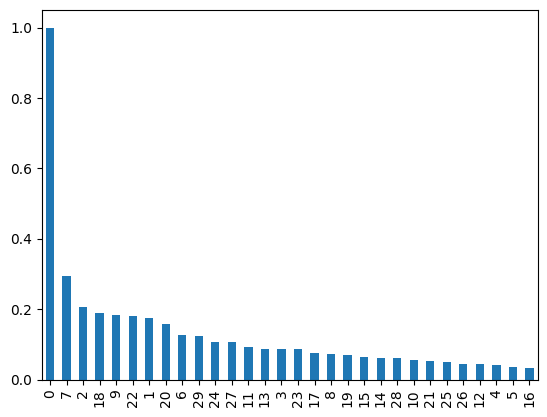

In [135]:
pd.DataFrame(arr).loc[0].sort_values(ascending = False).head(30).plot(kind = 'bar')

In [136]:
short_trump_df['text_body'].loc[7]

'Ο Κάρνεϊ δήλωσε πριν από την επίσκεψη ότι η συνάντηση θα επικεντρώσει στους δασμούς και τις διμερείς σχέσεις μεταξύ των δύο χωρών. Ο Τραμπ ωστόσο δήλωσε χθες, Δευτέρα, πως «δεν είναι σίγουρος» για ποιο πράγμα «θέλει να με δει ο Κάρνεϊ. Φαντάζομαι πως θέλει να κάνει μια συμφωνία. Όλοι θέλουν». Ο Κάρνεϊ κέρδισε στις 28 Απριλίου τις εκλογές στον Καναδά, με τους ψηφοφόρους να επιβραβεύουν την αυστηρή στάση του κατά του Τραμπ. Ο Τραμπ έχει επανειλημμένα απειλήσει να προσαρτήσει τον Καναδά ως 51η πολιτεία των Ηνωμένων Πολιτειών. Έχει επίσης επιβάλει υψηλούς δασμούς στη γειτονική χώρα, η οικονομία της οποίας διαπλέκεται στενά με αυτή των Ηνωμένων Πολιτειών. Μετά τη νίκη του Φιλελεύθερου Κόμματός του στις βουλευτικές εκλογές της περασμένης εβδομάδας, ο Κάρνεϊ υποσχέθηκε να αντιταχθεί σθεναρά στις επιθετικές πολιτικές της αμερικανικής κυβέρνησης. Στην επινίκια ομιλία του, ο Κάρνεϊ δήλωσε: «Ο πρόεδρος Τραμπ επιχειρεί να μας καταβάλει ώστε να μας έχει στη διάθεσή του. Αυτό δεν θα συμβεί ποτέ». «

In [137]:
short_trump_df['text_body'].loc[2]

'Το Φιλελεύθερο κόμμα του Κάρνεϊ κέρδισε τις εκλογές της 28ης Απριλίου με την υπόσχεση ότι θα αντιμετωπίσει τον Τραμπ και θα σφυρηλατήσει μια νέα, διμερή σχέση, οικονομική και ασφαλείας, με τις ΗΠΑ. Λίγο πριν από την άφιξη του Κάρνεϊ πάντως, ο Τραμπ έδειξε τις προθέσεις του με μια ανάρτησή του στον ιστότοπό του. «Ανυπομονώ να συναντηθώ με τον νέο πρωθυπουργό του Καναδά, τον Μαρκ Κάρνεϊ. Θέλω πολύ να συνεργαστώ μαζί του αλλά δεν μπορώ να καταλάβω μια απλή αλήθεια: Γιατί η Αμερική επιδοτεί τον Καναδά με 200 δισεκ. δολάρια τον χρόνο, εκτός από τη δωρεάν στρατιωτική προστασία και πολλά άλλα πράγματα που του δίνει; Δεν χρειαζόμαστε τα αυτοκίνητά τους, δεν χρειαζόμαστε την ενέργειά τους, δεν χρειαζόμαστε την ξυλεία τους, δεν χρειαζόμαστε τίποτα από ό,τι έχουν, παρά μόνο τη φιλία τους που ελπίζουμε ότι θα διατηρήσουμε. Αυτοί, από την άλλη, χρειάζονται τα πάντα από εμάς! Ο πρωθυπουργός θα φτάσει σύντομα και αυτή θα είναι, πιθανότατα, η μοναδική σημαντική ερώτησή μου». '

<Axes: >

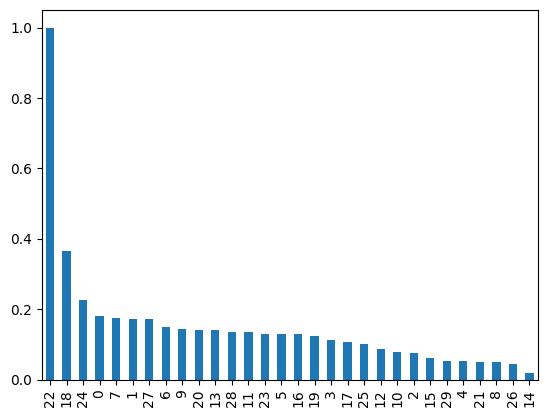

In [138]:
pd.DataFrame(arr).loc[22].sort_values(ascending = False).head(30).plot(kind = 'bar')

<Axes: >

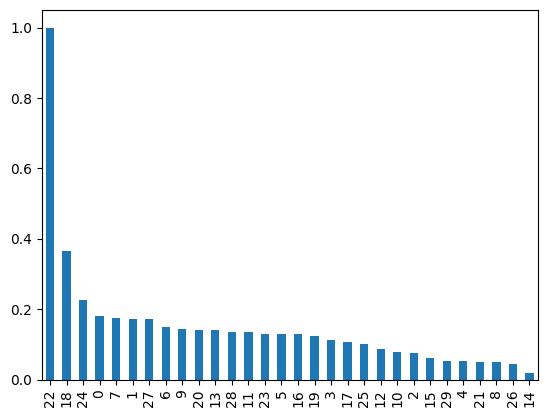

In [139]:
pd.DataFrame(arr).loc[22].sort_values(ascending = False).tail(30).plot(kind = 'bar')

In [140]:
arr = cosine_similarity(tfidf_matrix_train[0:10], tfidf_matrix_train[0:10])

<Axes: title={'center': 'Βαθμός ομοιότητας των 10 πρώτων άρθρων'}>

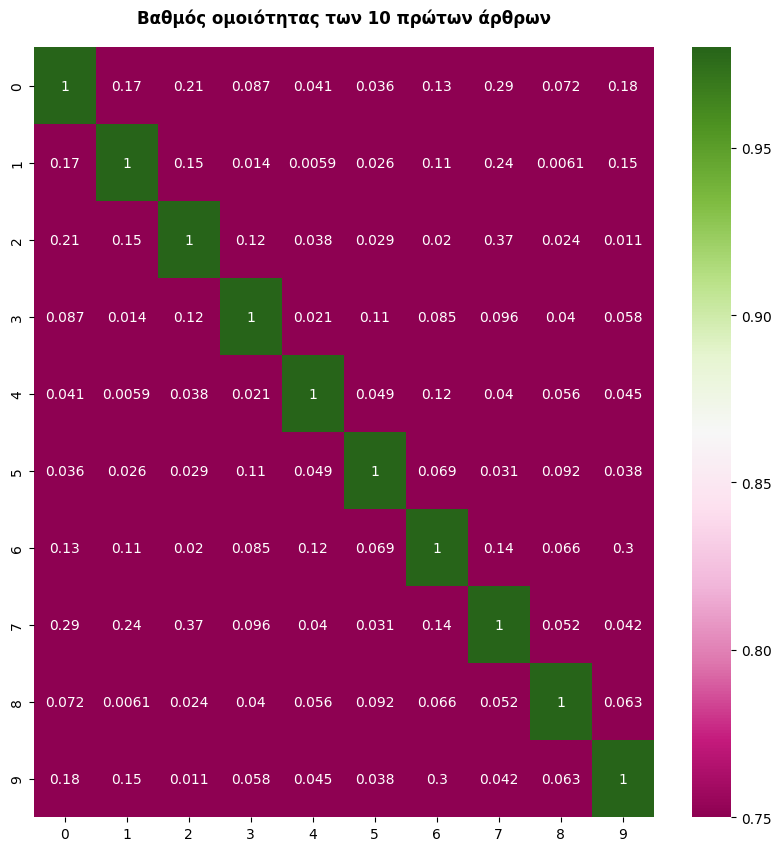

In [141]:
plt.figure(figsize=(10, 10))
# annot = True to print the values inside the square
plt.title('Βαθμός ομοιότητας των 10 πρώτων άρθρων', y=1.02, fontweight='bold') # το y ορίζει την απόσταση του τίτλου από το γράφημα

sns.heatmap(data=arr, annot=True, vmin=0.75, vmax=0.98, cmap="PiYG")

#plt.savefig('<το path και το όνομα του αρχείου>.png')

<Axes: title={'center': 'Βαθμός ομοιότητας των 10 πρώτων άρθρων'}>

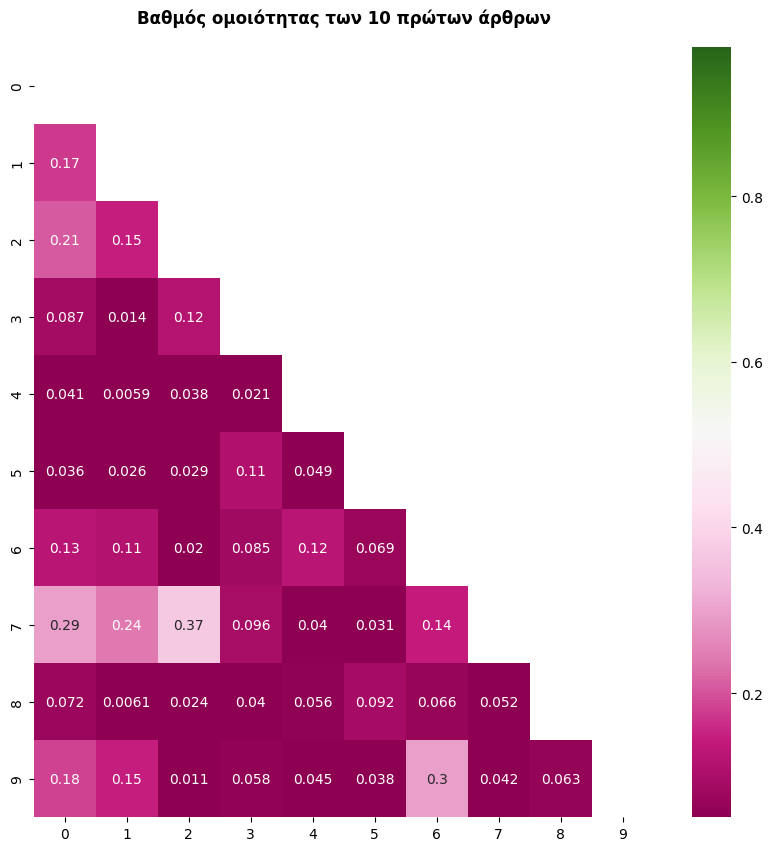

In [142]:
plt.figure(figsize=(10, 10))
# annot = True to print the values inside the square
plt.title('Βαθμός ομοιότητας των 10 πρώτων άρθρων', y=1.02, fontweight='bold') # το y ορίζει την απόσταση του τίτλου από το γράφημα

# mask
mask = np.triu(np.ones_like(arr, dtype=bool))
sns.heatmap(data=arr, annot=True, vmin=0.05, vmax=0.98, cmap="PiYG", mask=mask)

#plt.savefig('<το path και το όνομα του αρχείου>.png')